# LA County COVID-19 Cases by Neighborhoods

Use LA County's [countywide statistical areas](http://geohub.lacity.org/datasets/lacounty::countywide-statistical-areas-csa) and look at trends in cases and new cases by neighborhood.

**Related daily reports:** 
1. **[US counties report on cases and deaths for select major cities](https://cityoflosangeles.github.io/covid19-indicators/us-county-trends.html)**
1. **[Los Angeles County, detailed indicators](https://cityoflosangeles.github.io/covid19-indicators/coronavirus-stats.html)**

Code available in GitHub: [https://github.com/CityOfLosAngeles/covid19-indicators](https://github.com/CityOfLosAngeles/covid19-indicators)
<br>
Get informed with [public health research](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/reopening-sources.md)

In [4]:
import altair as alt
import altair_saver
import numpy as np
import os
import pandas as pd
import pytz

import default_parameters
import make_charts
import neighborhood_utils

from datetime import date, datetime, timedelta
from IPython.display import display_html, Markdown, HTML, Image

# Default parameters
time_zone = default_parameters.time_zone
start_date = default_parameters.start_date
today_date = default_parameters.today_date

fulldate_format = default_parameters.fulldate_format
monthdate_format = default_parameters.monthdate_format

time_zone = default_parameters.time_zone
yesterday_date = default_parameters.yesterday_date
two_days_ago = default_parameters.two_days_ago
two_weeks_ago = default_parameters.two_weeks_ago
one_week_ago = default_parameters.one_week_ago
one_month_ago = default_parameters.one_month_ago

start_date = date(2020, 4, 1)

In [2]:
# Prepare neighborhood case data, testing data, and merge
def prep_data(start_date):
    df1 = neighborhood_utils.clean_data()

    df1 = (df1[(df1.date >= start_date) & (df1.aggregate_region != "Long Beach")]
          .sort_values(["aggregate_region", "date"])
          .reset_index(drop=True)
         )

    df2 = neighborhood_utils.clean_testing_data()

    df = pd.merge(df1, df2.drop(columns = "region_num"), 
                  on = ["aggregate_region", "population", "date", "date2"], 
                  how = "left", validate = "1:1")
    return df

In [8]:
df = prep_data(start_date)

neighborhoods = list(df.aggregate_region.unique())

In [ ]:
display(Markdown(
        f"Report updated: {default_parameters.today_date.strftime(fulldate_format)}; "
        f"data available through {data_through.strftime(fulldate_format)}."
    )
)

In [37]:
title_font_size = 9
font_name = make_charts.font_name
grid_opacity = make_charts.grid_opacity
domain_opacity = make_charts.domain_opacity
stroke_opacity = make_charts.stroke_opacity
chart_width = make_charts.chart_width
chart_height = make_charts.chart_height
time_unit = make_charts.time_unit

navy = make_charts.blue
light_gray = make_charts.light_gray
gray = make_charts.gray

def setup_chart(df, neighborhood, chart_type):
    if chart_type == "cases":
        plot_col = "cases_avg7"
        p25_col = "cases_p25"
        p75_col = "cases_p75"
        chart_title = f"{neighborhood}: Cases"
    
    if chart_type == "new_cases":
        plot_col = "new_cases_avg7"
        p25_col = ""
        p75_col = ""
        chart_title = f"{neighborhood}: New Cases"
    
    if chart_type == "normalized_cases":
        plot_col = "cases_per100k_avg7"
        chart_title = f"{neighborhood}: Cases per 100k"
        p25_col = "ncases_p25"
        p75_col = "ncases_p75"
        
    
    base = (
        alt.Chart(df.drop(columns = "date"))
        .encode(
            x=alt.X("date2", timeUnit = time_unit,
                    title="date", axis=alt.Axis(format=monthdate_format)
                   )
        )
    )
    
    base_2weeks = (
        alt.Chart(df[df.date >= two_weeks_ago].drop(columns = "date"))
        .encode(
            x=alt.X("date2", timeUnit = time_unit,
                    title="date", axis=alt.Axis(format=monthdate_format)
                   )
        )
    )
    
    # Make cases charts
    cases_line = (base
        .mark_line()
        .encode(
            y=alt.Y(plot_col, title="7-day avg"),
            color=alt.value(navy),
        )
    )
    
    cases_shaded = (base_2weeks
        .mark_area()
        .encode(
            y=alt.Y(plot_col, title="7-day avg"),
            color=alt.value(light_gray)
        )
    )
    
    ptile25_line = (base
        .mark_line()
        .encode(
            y=alt.Y(p25_col, title="7-day avg"),
            color=alt.value(gray),
        )
    )
    
    ptile75_line = (base
        .mark_line()
        .encode(
            y=alt.Y(p75_col, title="7-day avg"),
            color=alt.value(gray),
        )
    )
    
    if (chart_type == "cases") or (chart_type == "normalized_cases"):
        chart =  ((cases_shaded + cases_line + ptile25_line + ptile75_line)
                  .properties(title=chart_title, height=chart_height, width=chart_width)
                 )
                
    
    if chart_type == "new_cases":
        chart = ((cases_shaded + cases_line)
                .properties(title=chart_title, height=chart_height, width=chart_width)
                )
    
    return chart

In [38]:
def summary_sentence(df, neighborhood):
    extract_col = "cases"
    cases_1month = df[df.date == one_month_ago][extract_col].iloc[0]
    cases_2weeks = df[df.date == two_weeks_ago][extract_col].iloc[0]
    cases_1week = df[df.date == one_week_ago][extract_col].iloc[0]
    cases_yesterday = df[df.date == yesterday_date][extract_col].iloc[0]
    
    pct_positive_2days = (df[df.date == two_days_ago]["pct_positive"].iloc[0] * 100).round(1)
    positive_per1k_2days = df[df.date == two_days_ago]["positive_per1k"].iloc[0].round(2)
    
    try:
        extract_col2 = "cases_per100k"
        n_cases_1week = df[df.date == one_week_ago][extract_col2].iloc[0].round(2)
        n_cases_yesterday = df[df.date == yesterday_date][extract_col2].iloc[0].round(2)
        
        pct_change = (((n_cases_yesterday - n_cases_1week) / n_cases_1week) * 100).round(1)
                     
        ranking = df[df.date == yesterday_date]["rank"].iloc[0].astype(int)
        max_rank = df[df.date == yesterday_date]["max_rank"].iloc[0].astype(int)
        
        
        display(Markdown(
            f"Cumulative cases reported in {neighborhood}: "
            f"{cases_1month:,} cases a month ago; {cases_2weeks:,} cases 2 weeks ago; " 
            f"{cases_1week:,} cases 1 week ago; {cases_yesterday:,} cases yesterday. "
            f"This translates to a <strong>{pct_change}% </strong> change in the past week. "
            f"Of those tested so far, {pct_positive_2days}% tested positive, with persons testing positive at a "
            f"rate of {positive_per1k_2days:,} per 1k. "
            f"As of {yesterday_date.strftime(fulldate_format)}, "
            f"{neighborhood} ranked <strong> {ranking} out of {max_rank} </strong> neighborhoods "
            "on cases per 100k <i>(1 being the most severely hit)</i>."
            )
        )   
    except AttributeError:
         display(Markdown(
            f"Cumulative cases reported in {neighborhood}: "
            f"{cases_1month} cases a month ago; {cases_2weeks} cases 2 weeks ago; " 
            f"{cases_1week} cases 1 week ago. "
            f"{neighborhood} has missing data; cases per 100k and rankings based on cases per 100k "
             "cannot be calculated. "
            )
        )        

In [39]:
def make_chart(df, neighborhood):
    
    subset_df = df[df.aggregate_region == neighborhood]
    
    cases_chart = setup_chart(subset_df, neighborhood, "cases")
    ncases_chart = setup_chart(subset_df, neighborhood, "normalized_cases")
    new_cases_chart = setup_chart(subset_df, neighborhood, "new_cases")
    
    combined_chart = (
        alt.hconcat(cases_chart, ncases_chart, new_cases_chart)
        .configure_title(
            fontSize=title_font_size, font=font_name, anchor="middle", color="black"
        )
        .configure_axis(gridOpacity=grid_opacity, domainOpacity=domain_opacity)
        .configure_view(strokeOpacity=stroke_opacity)
    )
    
    display(Markdown(f"#### {neighborhood}"))
    summary_sentence(subset_df, neighborhood)

    make_charts.show_svg(combined_chart)

<a id='top'></a>

## Neighborhoods by Region
<strong>City of LA: </strong> <a href='Acton'>Acton</a>, 
<br>
<strong>LA County Incorporated Cities:</strong> [Agoura Hills](#agoura_hills), 
[Alhambra](#alhambra), 
[Arcadia](#arcadia), 
Artesia, Avalon, 
[Azusa](#azusa), 
[Baldwin Park](#baldwin_park), 
[Bell](#bell), 
Bell Gardens,
Bellflower,
[Beverly Hills](#beverly_hills)
<br>
<strong>Unincorporated LA County:</strong> 
[Hacienda Heights](#hacienda_heights), 
[Rowland Heights](#rowland_heights), 
<br>
<br>
<strong><span style='color:f"#515252"'>The 25th and 75th percentile of cases and cases per 100k are calculated each day and drawn in gray.</span></strong>

<strong><span style='color:#1696D2'>The neighborhood's own trend is drawn in blue.</span></strong>

The percentiles provide context to whether a neighborhood's cases are relatively high or lower compared to other parts of the county. Data from the past 2 weeks are shaded in gray.

**Note:** Some neighborhoods report cases, but do not have population data. Rankings are calculated using cases per 100k to normalize across population differences. Neighborhoods without population data are excluded from the rankings.
Also, since rolling averages are used, decimals are possible, and are rounded to 1 decimal place. 

#### Acton

Cumulative cases reported in Acton: 434 cases a month ago, 494 cases 2 weeks ago, 534 cases 1 week ago, and 597 cases yesterday. This translates to a <strong>11.8% </strong> change in the past week. Of those tested so far, 9.1% tested positive, with persons testing positive at a rate of 19.89 per 1k. As of 11/24/20, Acton ranked <strong> 120 out of 167 </strong> neighborhoods on cases per 100k <i>(1 being the most severely hit)</i>.

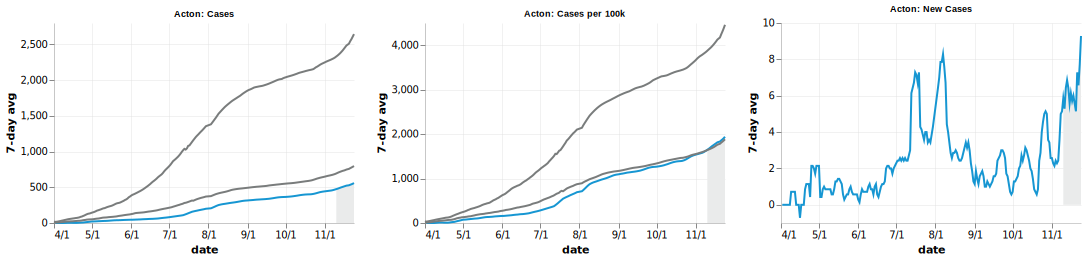

#### Agoura Hills

Cumulative cases reported in Agoura Hills: 252 cases a month ago, 278 cases 2 weeks ago, 295 cases 1 week ago, and 325 cases yesterday. This translates to a <strong>10.2% </strong> change in the past week. Of those tested so far, 3.5% tested positive, with persons testing positive at a rate of 8.37 per 1k. As of 11/24/20, Agoura Hills ranked <strong> 160 out of 167 </strong> neighborhoods on cases per 100k <i>(1 being the most severely hit)</i>.

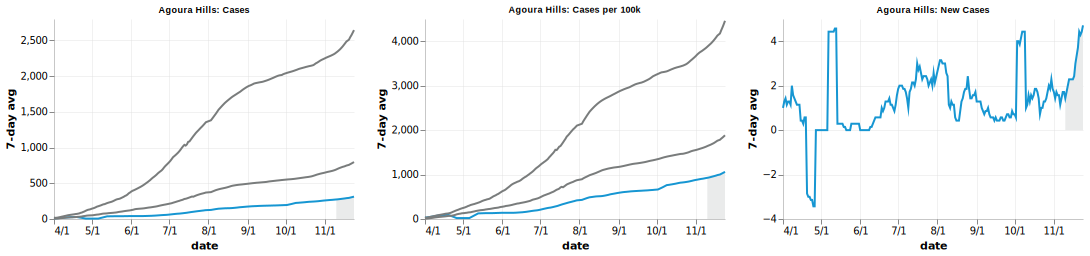

#### Alhambra

Cumulative cases reported in Alhambra: 1,422 cases a month ago, 1,514 cases 2 weeks ago, 1,610 cases 1 week ago, and 1,754 cases yesterday. This translates to a <strong>8.9% </strong> change in the past week. Of those tested so far, 6.7% tested positive, with persons testing positive at a rate of 19.88 per 1k. As of 11/24/20, Alhambra ranked <strong> 121 out of 167 </strong> neighborhoods on cases per 100k <i>(1 being the most severely hit)</i>.

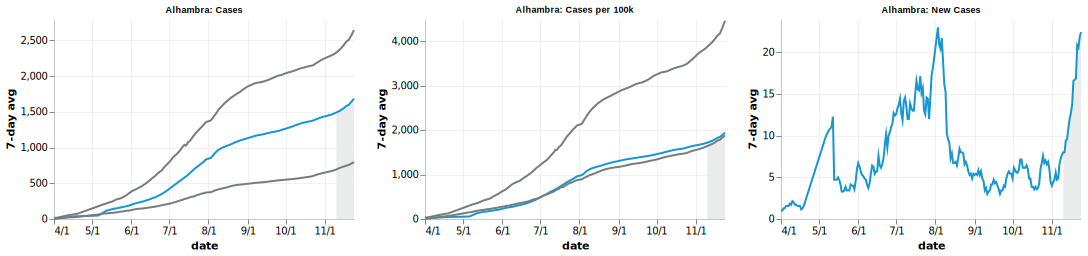

#### Altadena

Cumulative cases reported in Altadena: 868 cases a month ago, 921 cases 2 weeks ago, 977 cases 1 week ago, and 1,070 cases yesterday. This translates to a <strong>9.5% </strong> change in the past week. Of those tested so far, 5.3% tested positive, with persons testing positive at a rate of 18.21 per 1k. As of 11/24/20, Altadena ranked <strong> 123 out of 167 </strong> neighborhoods on cases per 100k <i>(1 being the most severely hit)</i>.

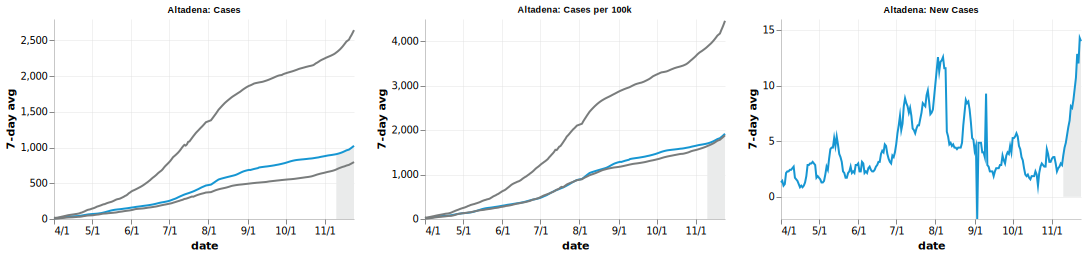

In [62]:
neighborhoods2 = neighborhoods[0:4]
for c in neighborhoods2:
    HTML(f"<a id={c}></a>")
    make_chart(df, c)
    display(HTML("<a href=#top>Return to top</a>"))